In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import cv2
from  matplotlib.colors import LinearSegmentedColormap
from scipy.signal import butter, lfilter, iirnotch, filtfilt, resample, find_peaks, savgol_filter
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from scipy.io import savemat
from src.xray import *
from src.tdt_support import *
from src.filters import *
from src.neural_analysis import *
from src.cort_processing import *
from src.wiener_filter import *
from src.utils import *

In [2]:
# %load ../src/cort_processing.py
import tdt
import time
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from scipy.signal import resample, find_peaks
from src.filters import *
from src.tdt_support import *
from src.neural_analysis import *
from src.wiener_filter import *
from sklearn.model_selection import KFold 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

def process_neural_kinangles(tdt, kin_angles, np_ts, threshold_multiplier,
        crop=(0,0), binsize=0.05, toe_height_path = ''):
    tdt_data = extract_tdt(tdt)
    angles_list, kinematics = extract_anipose_angles(kin_angles)
    if toe_height_path:
        bp_list, bps = extract_anipose_3d(toe_height_path)
        toe_height = bps[0,:,1]
        kinematics = np.vstack((kinematics, toe_height))
        ss = stance_swing_dd(toe_height)
        kinematics = np.vstack((kinematics, ss))
    
    tdt_data, kinematics = crop_data(tdt_data, kinematics, np_ts, crop)

    fs = tdt_data['fs']
    tdt_data['neural'] = filter_neural(tdt_data['neural'], fs) #bandpass
    tdt_data['neural'] = remove_artifacts(tdt_data['neural'], fs)
    
    spikes = autothreshold_crossings(tdt_data['neural'], threshold_multiplier)
    firing_rates = spike_binner(spikes, fs, binsize)

    resampled_angles = resample(kinematics, firing_rates.shape[1], axis=1)
    if toe_height_path:
        resampled_angles[-1,:] = resampled_angles[-1,:] > 0.1
    return firing_rates, resampled_angles

def convert_to_phase(angle):
    peaks, nada = find_peaks(angle, prominence=10)
    peaks = np.append(peaks, np.size(angle))
    peaks = np.insert(peaks, 0, 0)
    gait_phase_list = []

    for i in range(np.size(peaks)-1):
        end = peaks[i+1]
        start = peaks[i]

        phase = np.sin(np.linspace(0.0, 2.0*math.pi, num=end-start,
            endpoint=False))
        gait_phase_list.append(phase)
    
    return np.hstack(gait_phase_list), gait_phase_list


def convert_to_limbfootphase(limbfoot_angle):
    peaks = extract_peaks(limbfoot_angle, 115)
    gait_phase_list = []
    for i in range(np.size(peaks)-1):
        end = peaks[i+1]
        start = peaks[i]

        phase = np.sin(np.linspace(0.0, 2.0*math.pi, num=end-start,
            endpoint=False))
        gait_phase_list.append(phase)

    starting_index = peaks[0]
    ending_index = peaks[-1]
    return np.hstack(gait_phase_list), starting_index, ending_index, peaks

def stance_swing(toe_height):
    peaks = extract_peaks(toe_height, 12)
    peaks = np.append(peaks, np.size(toe_height))
    peaks = np.insert(peaks, 0, 0)
    ss_list = []
    

    for i in range(np.size(peaks)-1):
        
        end = peaks[i+1]
        start = peaks[i]
        

        gait = toe_height[start:end]
        #dx = np.gradient(gait)
        #ddx = np.gradient(dx)

        #gait_peaks = extract_peaks(ddx, 0.02)
        minny = np.amin(gait)
        ss = gait > minny + 2

        ss_list.append(ss)


    stance_swing = np.hstack(ss_list)

    return stance_swing

def stance_swing_forelimb(forelimb):
    peaks, nada = find_peaks(forelimb, prominence=10)
    peaks = np.append(peaks, np.size(forelimb))
    peaks = np.insert(peaks, 0, 0)
    ss_list = []
    for i in range(np.size(peaks)-1):
        end = peaks[i+1]
        start = peaks[i]

        temp = forelimb[start:end]
        valley = start + np.argmin(temp)

        stance = np.ones(forelimb[start:valley].shape)
        swing = np.zeros(forelimb[valley:end].shape)
        ss = np.hstack((stance, swing))
        ss_list.append(ss)

    stance_swing = np.hstack(ss_list)
    return stance_swing

def stance_swing_dd(toe_height):
    peaks = extract_peaks(toe_height, 12)
    peaks = np.append(peaks, np.size(toe_height))
    peaks = np.insert(peaks, 0, 0)
    ss_list = []

    for i in range(np.size(peaks)-1):
        end=peaks[i+1]
        start=peaks[i]

        gait = toe_height[start:end]
        dx = np.gradient(gait)
        ddx = np.gradient(dx)

        ddx_peaks = extract_peaks(ddx, 0.02)
        if np.size(ddx_peaks) == 2:
            ss = np.ones(np.size(gait), dtype=bool)
            ss[ddx_peaks[0]:ddx_peaks[1]] = 0
        else:
            minny = np.amin(gait)
            ss = gait>minny+2

        ss_list.append(ss)

    stance_swing = np.hstack(ss_list)
    return stance_swing


    




def linear_decoder(firing_rates, kinematics, n=10, l2=0):
    #rates_format, angles_format = format_data(firing_rates.T, kinematics.T, n)
    h = train_wiener_filter(rates_format, angles_format, l2)

    return h

def decode_kfolds(rates, kins, k=10):
    kf = KFold(n_splits=k)

    h_list = []

    vaf_array = np.zeros((kins.shape[1], k))
    index=0
    best_vaf=0
    for train_index, test_index in kf.split(rates):


        train_x, test_x = rates[train_index, :], rates[test_index,:]
        train_y, test_y = kins[train_index, :], kins[test_index, :]

        h=train_wiener_filter(train_x, train_y)
        predic_y = test_wiener_filter(test_x, h)
        
        for j in range(predic_y.shape[1]):
            vaf_array[j, index] = vaf(test_y[:,j], predic_y[:,j])
            
        if vaf_array[3, index] > best_vaf:
            best_vaf = vaf_array[3, index]
            best_h = h
            final_test_x = test_x
            final_test_y = test_y

        index = index+1
    
    return best_h, vaf_array, final_test_x, final_test_y


def classify_kfolds(rates, stance_swing, k=10):
    kf = KFold(n_splits=k)

    accuracy_list = []
    best_accuracy=0
    clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=10000,
       tol=1e-3))
    best_model = clf
    for train_index, test_index in kf.split(rates):


        train_x, test_x = rates[train_index, :], rates[test_index,:]
        train_y, test_y = stance_swing[train_index], stance_swing[test_index]

        clf.fit(train_x, train_y)
        y_pred = clf.predict(test_x)
        pred_accuracy = accuracy_score(test_y, y_pred)
        accuracy_list.append(pred_accuracy)
        if best_accuracy < pred_accuracy:
            best_accuracy = pred_accuracy
            best_model = clf
            final_test_x = test_x
            final_test_y = test_y
    
    return best_model, accuracy_list, final_test_x, final_test_y

def decode_kfolds_forelimb(forelimb_kins, hindlimb_kins, k=10):
    kf = KFold(n_splits=k)

    h_list = []

    vaf_array = np.zeros((hindlimb_kins.shape[1], k))
    index=0
    best_vaf=0
    for train_index, test_index in kf.split(forelimb_kins):


        train_x, test_x = forelimb_kins[train_index], forelimb_kins[test_index]
        train_y, test_y = hindlimb_kins[train_index, :], hindlimb_kins[test_index, :]

        h=train_wiener_filter(train_x, train_y)
        predic_y = test_wiener_filter(test_x, h)
        h_list.append(h)
        for j in range(predic_y.shape[1]):
            vaf_array[j, index] = vaf(test_y[:,j], predic_y[:,j])
         
        if vaf_array[2, index] > best_vaf:
            best_vaf = vaf_array[2, index]
            best_h = h
            final_test_x = test_x
            final_test_y = test_y


        index=index+1
    
    return best_h, vaf_array, final_test_x, final_test_y



def stitch_data(rates_list, kin_list, n=10):
    formatted_rates = []
    formatted_angles = []

    for i in range(len(rates_list)):
        f_rate, f_angle = format_data(rates_list[i].T, kin_list[i].T, n)
        formatted_rates.append(f_rate.T)
        formatted_angles.append(f_angle.T)

    rates = np.hstack(formatted_rates).T
    kin = np.hstack(formatted_angles).T
    return rates, kin

def extract_peaks(angles, thres_height=115):
    peaks, nada = find_peaks(angles, height=thres_height)
    return peaks

def find_bad_gaits(peaks):
    average_gait_samples = np.average(np.diff(peaks))
    above = 1.25 * average_gait_samples
    below = .8 * average_gait_samples

    bad_above = np.argwhere(np.diff(peaks) > above)
    bad_below = np.argwhere(np.diff(peaks) < below)

    bads = np.squeeze(np.concatenate((bad_above, bad_below)))

    return bads.tolist()

def remove_bad_gaits(rates, angles, peak_threshold=115):
    peaks = extract_peaks(angles[3,:], peak_threshold)
    bads = find_bad_gaits(peaks)

    rates_list = []
    angles_list = []

    for i in range(np.size(peaks)-1):
        if i in bads:
            continue
        first = peaks[i]
        last=peaks[i+1]
        gait_rates = rates[:, first:last]
        gait_angles = angles[:, first:last]

        rates_list.append(gait_rates)
        angles_list.append(gait_angles)


    rebuilt_rates = np.hstack(rates_list)
    rebuilt_angles = np.hstack(angles_list)
    return rebuilt_rates, rebuilt_angles 

def extract_gait(rates, angles, thres, bool_resample=False):
    peaks = extract_peaks(angles,thres)
    rates_list = []
    angles_list = []

    avg_samples = int(np.round(np.average(np.diff(peaks))))

    for i in range(np.size(peaks)-1):
        first = peaks[i]
        last = peaks[i+1]
        gait_rates = rates[:, first:last]
        gait_angles = angles[first:last]
        if bool_resample:
            gait_rates = resample(gait_rates, avg_samples, axis=1)
            gait_angles = resample(gait_angles, avg_samples)
        rates_list.append(gait_rates)
        angles_list.append(gait_angles)

    return rates_list, angles_list, peaks

def vid_from_gait(crop, angles_list, gait_number, video, peaks, filename, binsize=0.05,
        framerate=1):
    bin_number = np.size(np.hstack(angles_list[0:gait_number]))

    frame_iter = int(binsize*200)
    start_frame = crop[0]*200 + ((peaks[0]+bin_number) * frame_iter)
    end_frame = start_frame + len(angles_list[gait_number]) * frame_iter

    directory = '/home/diya/Documents/rat-fes/results/movies/{}-{}/'.format(filename, gait_number)
    os.mkdir(directory)
    
    angles = angles_list[gait_number]

    fig0 = plt.figure(figsize = (720/96, 440/96), dpi=96)
    ax0 = fig0.add_subplot(111)
    ax0.set_xlim(0, np.size(angles)-1)
    ax0.set_ylim(np.min(angles), np.max(angles))
    
    img_list = []

    for i in range(np.size(angles)):
        y = angles[0:i+1]
        x = np.arange(0,i+1)
        degree_num = int(angles[i])
        ax0.plot(x, y, c='blue')
        plt.savefig(directory + 'degree{}_{}'.format(i, degree_num), )
        time.sleep(.1)
        img_list.append(cv2.imread(directory +
            'degree{}_{}.png'.format(i, degree_num)))

    height = img_list[0].shape[0]
    width = img_list[0].shape[1]
    out = cv2.VideoWriter(directory + 'kin.mp4',
            cv2.VideoWriter_fourcc(*'DIVX'), framerate,(width, height))

    for img in img_list:
        out.write(np.array(img))

    out.release()
    

    cap = cv2.VideoCapture(video)
    img_list = []
    
    j=0
    for k in range(start_frame, end_frame, frame_iter):
        cap.set(1, k)
        ret, frame = cap.read()
        cv2.imwrite(directory + 'live_frame{}_{}.png'.format(k, int(angles[j])), frame)
        img_list.append(frame)
        j=j+1
    
    height = img_list[0].shape[0]
    width = img_list[0].shape[1]

    out = cv2.VideoWriter(directory + 'live_video.mp4',
            cv2.VideoWriter_fourcc(*'DIVX'), framerate,(width, height))
    for img in img_list:
        out.write(np.array(img))

    out.release()





In [2]:
tdt1 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-220303-161731'
kin1 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15_2022-03-03_200f-11e100g1.csv'
toe1 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15_2022-03-03_200f-11e100g1.csv'
np_ts1 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15_2022-03-03_200f-11e100g1.npy'
crop1 = (5,180)

tdt2 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-2-220303-162513'
kin2 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15-2_2022-03-03_200f-11e100g1.csv'
toe2 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15-2_2022-03-03_200f-11e100g1.csv'
np_ts2 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15-2_2022-03-03_200f-11e100g1.npy'
crop2 = (31,227)

tdt3 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-3-220303-163055'
kin3 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15-3_2022-03-03_200f-11e100g1.csv'
toe3 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15-3_2022-03-03_200f-11e100g1.csv'
np_ts3 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15-3_2022-03-03_200f-11e100g1.npy'
crop3 = (5,200)

tdt4 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/tdt/t0-030322-15-4-220303-163556'
kin4 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/angles/_t0-030322-15-4_2022-03-03_200f-11e100g1.csv'
toe4 = '/home/diya/Documents/rat-fes/data/DLC_anipose_models/anipose_t_march/session/pose-3d/_t0-030322-15-4_2022-03-03_200f-11e100g1.csv'
np_ts4 = '/home/diya/Documents/rat-fes/data/rat-t/03-03-22/vids/TIMESTAMPS_cam1_t0-030322-15-4_2022-03-03_200f-11e100g1.npy'
crop4 = (5,150)

In [3]:
rates1, angles1= process_neural_kinangles(tdt1, kin1, np_ts1, 3.0, crop1, binsize=0.05, toe_height_path = toe1)
rates2, angles2= process_neural_kinangles(tdt2, kin2, np_ts2, 3.0, crop2, binsize=0.05, toe_height_path = toe2)
rates3, angles3= process_neural_kinangles(tdt3, kin3, np_ts3, 3.0, crop3, binsize=0.05, toe_height_path = toe3)
rates4, angles4= process_neural_kinangles(tdt4, kin4, np_ts4, 3.0, crop4, binsize=0.05, toe_height_path = toe4)

#test_rates5, test_angles5 = process_neural_kinangles(tdt4, kin4, np_ts4, 3.0, test_crop, binsize=0.05)

rates_list = []
angles_list = []

rates_list.extend((rates1, rates2, rates3, rates4))
angles_list.extend((angles1, angles2, angles3, angles4))

read from t=0s to t=209.21s
read from t=0s to t=242.15s
read from t=0s to t=206.37s
read from t=0s to t=157.26s


In [4]:
rates, kins = stitch_data(rates_list, angles_list)

In [5]:
forelimb = kins[:,6]
limbfoot = kins[:,3]

#correlate = np.correlate(forelimb, limbfoot, mode='full')

In [6]:
phase, nada = convert_to_phase(limbfoot)

In [10]:
kins_ext = np.vstack((kins.T, phase)).T

In [45]:
print(total/2)

14190.5


2.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
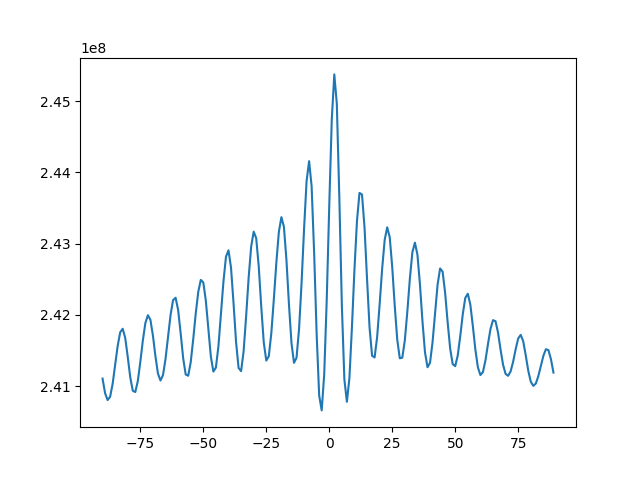

In [48]:
total = correlate.shape[0]
x_ = np.arange(total)
x=x_-((total-1)/2)

fig0 = plt.figure()
ax0 = fig0.add_subplot(111)
#ax0.plot(forelimb)
#ax0.plot(norm_limbfoot)
ax0.plot(x[14100:14280],correlate[14100:14280])

maxou = np.argmax(correlate) - ((total-1)/2)
print(maxou)

fig0.savefig('/home/diya/Documents/rat-fes/results/forelimb_figs/forelimb_limbfoot_correlation')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
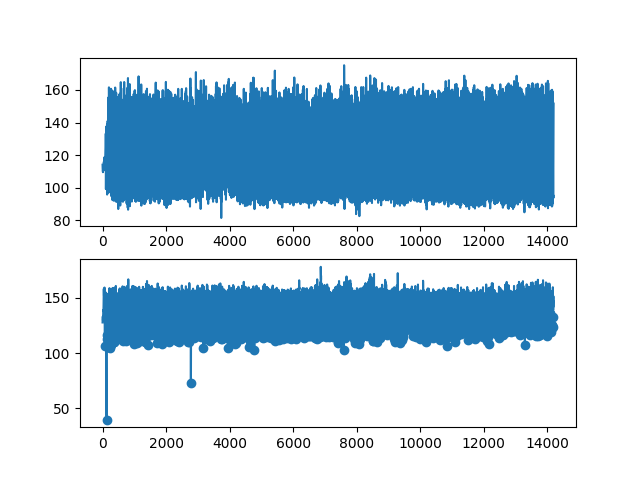

In [55]:
peaks, peak_heights = find_peaks(forelimb, prominence = 10)
valleys, nada = find_peaks(forelimb*-1, prominence=10)

fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.plot(limbfoot)
ax11=fig1.add_subplot(212, sharex=ax1)
ax11.plot(forelimb)
ax11.scatter(valleys, forelimb[valleys])

In [36]:
avg_peak = np.average(forelimb[peaks])
std = np.std(forelimb[peaks])
print(np.size(forelimb[peaks]))
print(np.sum(forelimb[peaks] > (avg_peak + (2*std))))

1337
32


In [12]:
forelimb_phase, f_phase_list = convert_to_phase(forelimb)
limbfoot_phase, l_phase_list = convert_to_phase(limbfoot)

print(forelimb_phase.shape)
print(limbfoot_phase.shape)

(14191,)
(14191,)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
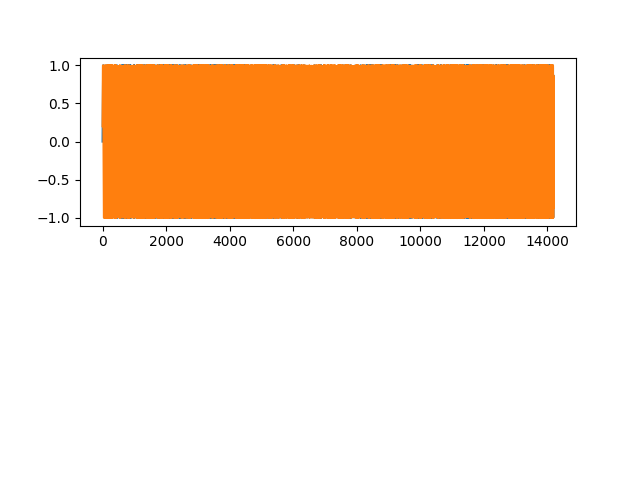

In [64]:
fig11 = plt.figure()
ax11 = fig11.add_subplot(211)
ax11.plot(limbfoot_phase[:-2])
ax11.plot(forelimb_phase[2:])

In [19]:
count=[]
for array in l_phase_list[1:-1]:
    count.append(np.size(array))
print(max(set(count), key = count.count))

#10 is the size that appears most 

10


In [15]:
kins_add = np.vstack((kins.T, forelimb_phase)).T
h, vaf_array, test_x, test_y = decode_kfolds(rates, kins_ext)

predic_kins = test_wiener_filter(test_x, h)
predic_forelimb_phase = predic_kins[:,-1]
predic_forelimb = predic_kins[:,6]
predic_forelimb_to_phase, nada = convert_to_phase(predic_forelimb)


In [ ]:
predic

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
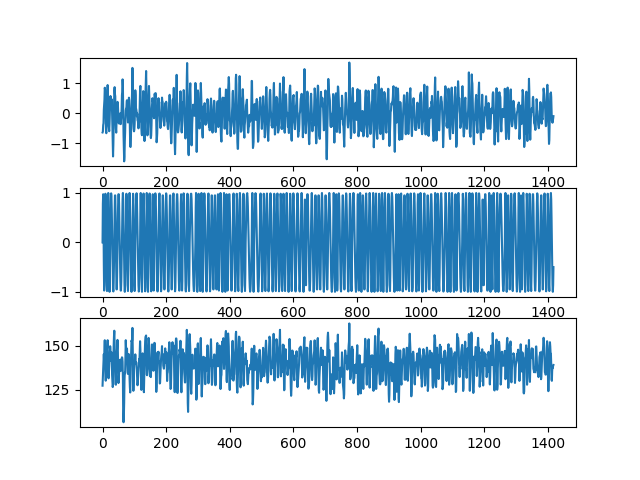

In [18]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(311)
ax2.plot(predic_forelimb_phase)
ax3 = fig2.add_subplot(312, sharex=ax2)
ax3.plot(predic_forelimb_to_phase)
ax4 = fig2.add_subplot(313, sharex=ax2)
ax4.plot(predic_forelimb)

0.470243861411097


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
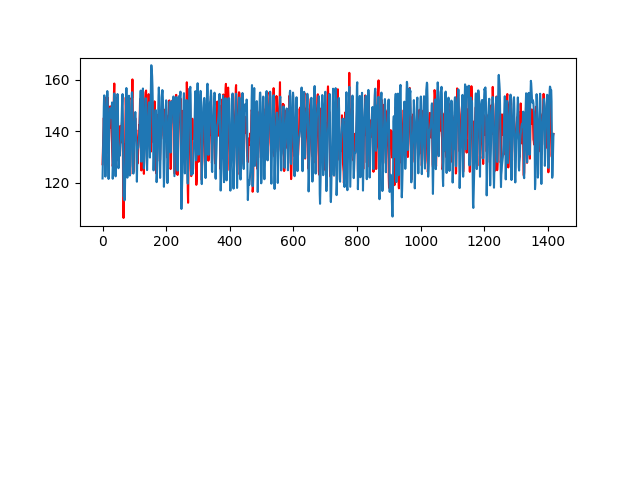

In [35]:
fig20 = plt.figure()
ax20 = fig20.add_subplot(211)
ax20.plot(predic_forelimb, c='red')
ax20.plot(test_y[:,6])

print(vaf(test_y[:,6], predic_forelimb))

In [65]:
h, vaf_array, test_x, test_y = decode_kfolds(rates, kins)

In [66]:
predic_kins = test_wiener_filter(test_x, h)
predic_forelimb = predic_kins[:,6]

#limbfoot = test_y[:,3]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
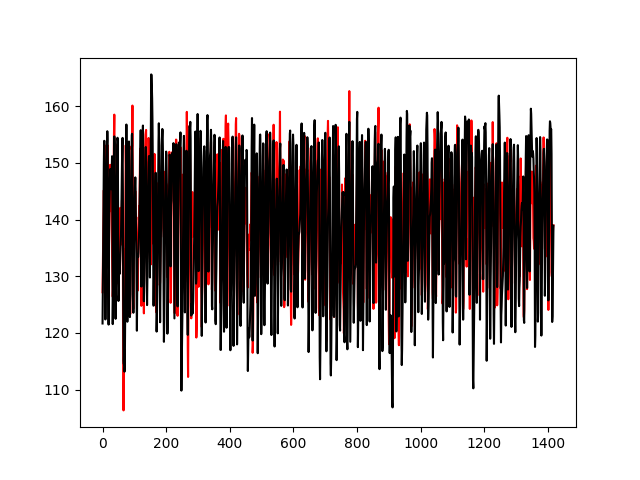

In [67]:
figb=plt.figure()
axb = figb.add_subplot(111)
axb.plot(predic_forelimb, c='red')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
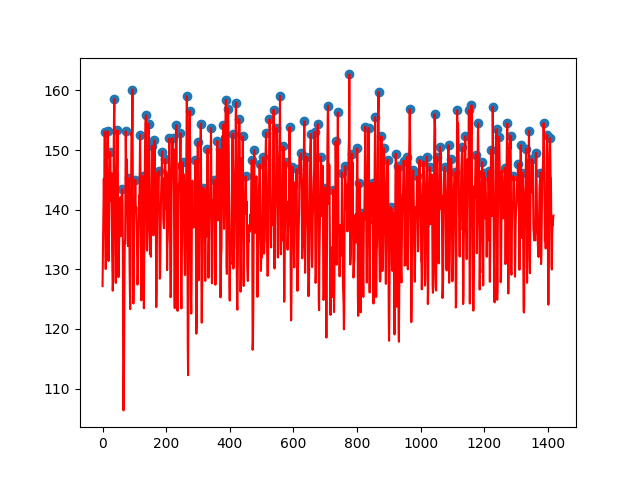

In [73]:
peaks, peak_heights = find_peaks(predic_forelimb, prominence = 10)
limbfoot = test_y[:,3]
figc=plt.figure()
axc = figc.add_subplot(111)
axc.plot(predic_forelimb, c='red')
axc.scatter(peaks, predic_forelimb[peaks])

In [74]:
predic_forelimb_phase, nada = convert_to_phase(predic_forelimb)
limbfoot_phase, nada = convert_to_phase(limbfoot)



In [76]:
print(predic_forelimb_phase.shape, limbfoot_phase.shape)

(1419,) (1419,)


0.41850648960914294


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
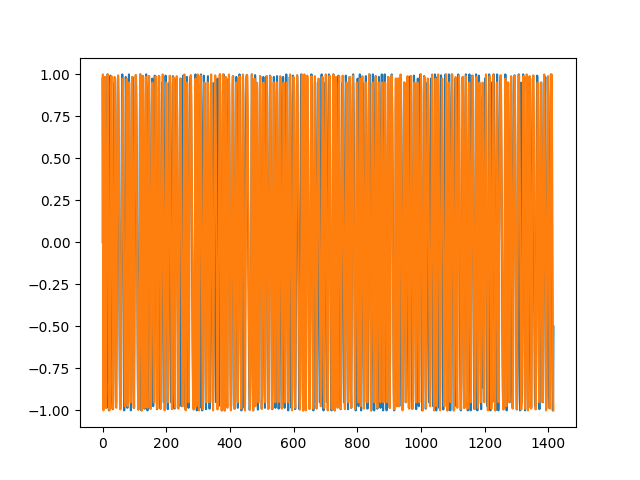

In [80]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.plot(predic_forelimb_phase[2:])
ax3.plot(limbfoot_phase[:-2])

print(vaf(limbfoot_phase[:-2], predic_forelimb_phase[2:]))

In [118]:
vaf(predic_forelimb_phase[2:], e_limbfoot_phase[:-2])

0.4236183273974845

In [52]:
phase_correlate = np.correlate(forelimb_phase[2:], limbfoot_phase[:-2], mode='full')

total = phase_correlate.shape[0]
x_ = np.arange(total)
x=x_-((total-1)/2)

phase_max = np.argmax(phase_correlate) - ((total-1)/2)
print(phase_max)

-1.5


/home/diya/anaconda3/envs/rat-fes/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
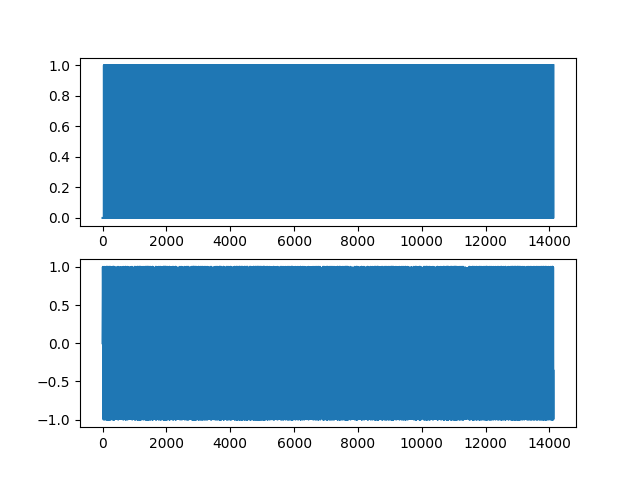

In [72]:
ss = kins[:,-1]
ss.shape

forelimb_phase, f_start, f_end, nada = convert_to_phase(forelimb)

fig5 = plt.figure()
ax5 = fig5.add_subplot(211)
ax5.plot(ss[f_start:f_end])
ax51 = fig5.add_subplot(212, sharex=ax5)
ax51.plot(forelimb_phase)



In [103]:
ss_forelimb = stance_swing_forelimb(forelimb)
limbfoot_phase, l_start, l_end, l_peaks = convert_to_phase(limbfoot)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
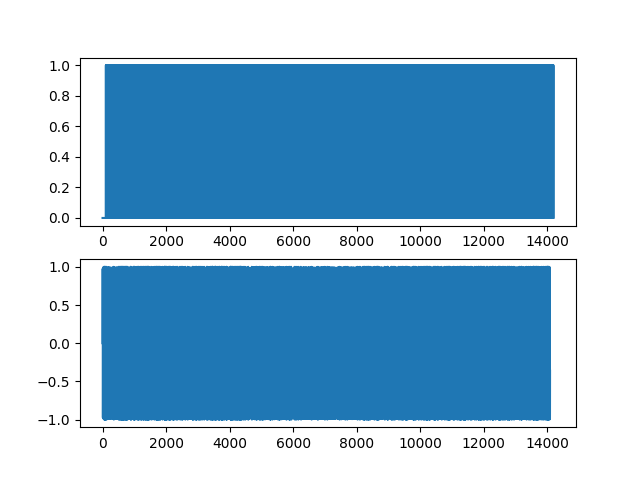

In [104]:
fig6 = plt.figure()
ax6 = fig6.add_subplot(211)
ax6.plot(ss)
ax61 = fig6.add_subplot(212, sharex=ax6)
ax61.plot(limbfoot_phase)

In [108]:
h = train_wiener_filter(limbfoot_phase, ss[l_start:l_end])

In [112]:
predic_phase = test_wiener_filter(limbfoot_phase, h)
predic_phase = predic_phase > .2

0.7913234876455553


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
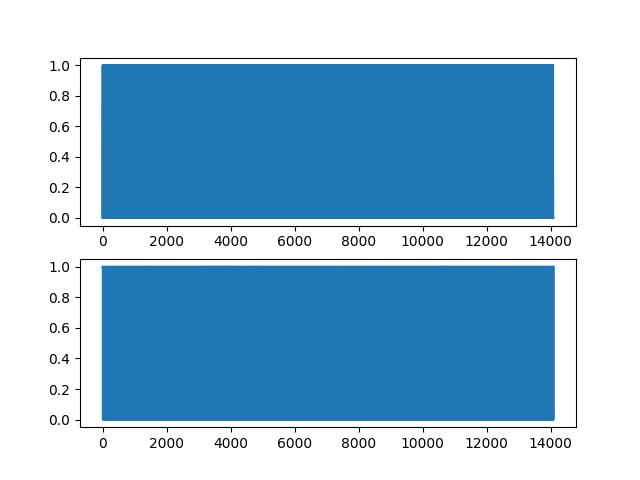

In [121]:
fig7 = plt.figure()
ax7 = fig7.add_subplot(211)
ax7.plot(ss[l_start:l_end])
ax71 = fig7.add_subplot(212, sharex=ax7)
ax71.plot(predic_phase)

print(classif_accuracy(ss[l_start:l_end], predic_phase))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
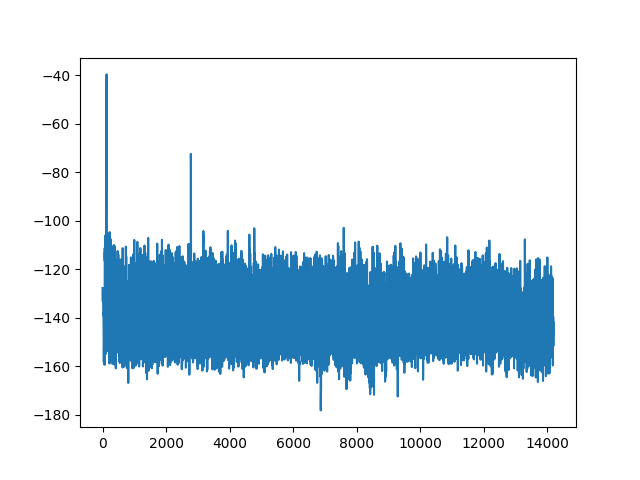

In [53]:
figgy = plt.figure()
axxy = figgy.add_subplot(111)
axxy.plot(forelimb*-1)

In [ ]:
phasey = {}

phasey[8] = np.sin(np.linspace(0.0, 2.0*math.pi, num=8, endpoint=False))
phasey[9] = np.sin(np.linspace(0.0, 2.0*math.pi, num=9, endpoint=False))
phasey[10] = np.sin(np.linspace(0.0, 2.0*math.pi, num=10, endpoint=False))
phasey[11] = np.sin(np.linspace(0.0, 2.0*math.pi, num=11, endpoint=False))
phasey[12] = np.sin(np.linspace(0.0, 2.0*math.pi, num=12, endpoint=False)

count_from_peak = -1
current_gait_speed=10

avg_peak = np.average(forelimb[peaks])
std = np.std(forelimb[peaks])
#print(np.size(forelimb[peaks]))
#print(np.sum(forelimb[peaks] > (avg_peak + (2*std))))
output = []
for rate in test_x:
    rt_predic_kin = test_wiener_filter(rate, h)
    rt_forelimb = rt_predic_kin[:,6]
    
    if count_from_peak = -1:
        #lets wait for a peak
        if rt_forelimb > avg_peak - (2*std):
            #ok we found a potential peak
            output.append(phasey[count_from_peak])
            count_from_peak = count_from_peak+1
            found_valley
            break
        else output.append(0)
        
    elif
    
    